In [1]:
import random
import torch
from PIL import Image
import pandas as pd
import torch.nn as nn
from glob import glob
import torch.optim as optim
import torch.utils.data
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from img_combiner import *
from dataset import *
import datetime
from architecture import *

img_dir = 'data'
img_path = glob(f'{img_dir}/images_train/*.png')
test_img_path = glob(f'{img_dir}/images_test/*.png')
samples = img_combiner(img_path)()
test_samples = img_combiner(test_img_path)()

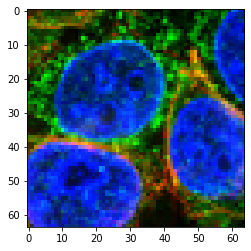

In [2]:
trans = transforms.ToPILImage()
plt.imshow(trans(samples[0]))

In [3]:
targs = pd.read_csv(f'{img_dir}/y_train.csv').cell_line

print(targs.value_counts())
replace_dict = {'MCF7':0, 'RT4':1, 'U-2 OS':2, 'A549':3,
                           'HEK 293':4, 'CACO-2':5, 'PC-3':6, 'HeLa':7, 'U-251 MG':8}

new_targs = targs.replace(replace_dict)
onehot_targets = torch.nn.functional.one_hot(torch.LongTensor(new_targs.values))

RT4         2100
CACO-2      1626
HEK 293     1378
MCF7        1082
U-2 OS       775
U-251 MG     768
PC-3         663
HeLa         632
A549         608
Name: cell_line, dtype: int64


5


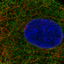

In [4]:
transform = transforms.Compose([transforms.ColorJitter(0.4)])

data_train = Dataset_train(samples, new_targs, transform)
data_test = Dataset_test(test_samples)

print(data_train[14][1])
trans(data_train[4][0])

In [5]:
data_train.targets.value_counts().sort_index()

0    1082
1    2100
2     775
3     608
4    1378
5    1626
6     663
7     632
8     768
Name: cell_line, dtype: int64

In [5]:
target_list = []

for _,t in data_train:
    target_list.append(t)

target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]
class_counts = [i for i in data_train.targets.value_counts().sort_index().values]
class_weights = 1./torch.tensor(class_counts, dtype=torch.float)
print(class_weights)
class_weights_all = class_weights[target_list]

weighted_sampler = torch.utils.data.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

trainloader = torch.utils.data.DataLoader(data_train, batch_size = 32, sampler=weighted_sampler)
testloader = torch.utils.data.DataLoader(data_test, batch_size = 1)

tensor([0.0009, 0.0005, 0.0013, 0.0016, 0.0007, 0.0006, 0.0015, 0.0016, 0.0013])


In [6]:
from torchvision.models import vgg, resnext50_32x4d
VGG = vgg.vgg13_bn(False)
resn = resnext50_32x4d(False)
feats = VGG.children()
features = nn.Sequential(*list(feats)[0])
net = Net2(features=features, num_classes=9)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00002)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

def train(net, loader, optimizer, epochs = 20, mode = ''):
    losses = []
    
    for epoch in range(epochs):
        #net.train()
        start_time = datetime.datetime.now()
        correct = 0
        total = 0
        rloss = 0.0
        
        for i, data in enumerate(loader):
            img, label = data
            img = img.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = net(img)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            rloss += loss.item()
            
            _, predicted = torch.max(output.data, 1)
            correct = torch.sum(predicted == label)
            total = len(data)
            
            if i > 0 and i % 150 == 0:
                print(f'Epoch: {epoch}/{epochs} | Iteration: [{i*len(data)}] | Loss: {loss.data}')
            
        scheduler.step()
        loss = rloss / len(loader.dataset)
        losses.append(loss)
        #print(f'Epoch: {epoch}/{epochs} | [{i*len(data)}/{len(loader.dataset)} | Loss: {loss} | Accuracy: {100*correct/total}')
        
    return losses

In [15]:
net.load_state_dict(torch.load('saves/vgg13_40ep_2try.pth'))

<All keys matched successfully>

In [16]:
net.to(device)
torch.autograd.set_detect_anomaly(True)
training = train(net, trainloader, optimizer)

training


Epoch: 0/20 | Iteration: [300] | Loss: 1.0013580322265625e-05
Epoch: 0/20 | Iteration: [600] | Loss: 2.0444393157958984e-05
Epoch: 1/20 | Iteration: [300] | Loss: 0.0001512467861175537
Epoch: 1/20 | Iteration: [600] | Loss: 0.00022932887077331543
Epoch: 2/20 | Iteration: [300] | Loss: 2.0384788513183594e-05
Epoch: 2/20 | Iteration: [600] | Loss: 1.2516975402832031e-05
Epoch: 3/20 | Iteration: [300] | Loss: 0.001053646206855774
Epoch: 3/20 | Iteration: [600] | Loss: 0.03259517252445221
Epoch: 4/20 | Iteration: [300] | Loss: 0.000270843505859375
Epoch: 4/20 | Iteration: [600] | Loss: 0.000188484787940979
Epoch: 5/20 | Iteration: [300] | Loss: 7.465481758117676e-05
Epoch: 5/20 | Iteration: [600] | Loss: 7.063150405883789e-06
Epoch: 6/20 | Iteration: [300] | Loss: 3.0934810638427734e-05
Epoch: 6/20 | Iteration: [600] | Loss: 2.5033950805664062e-06
Epoch: 7/20 | Iteration: [300] | Loss: 1.5169382095336914e-05
Epoch: 7/20 | Iteration: [600] | Loss: 0.00022141635417938232
Epoch: 8/20 | Iterat

[0.0001244609196982857,
 2.016503583528473e-05,
 1.9303759702317342e-05,
 0.00017329670126825275,
 0.0002763575910624624,
 2.013852949752364e-05,
 3.6875609048577243e-06,
 2.950556000750326e-06,
 3.983308421911987e-06,
 2.002803782044455e-06,
 1.6496762744711087e-06,
 3.3938570375062302e-06,
 0.0005934442485531056,
 2.5920460829851637e-05,
 1.5389981008199758e-05,
 4.149561877860579e-06,
 1.6495656605772798e-06,
 2.0742209077475473e-06,
 3.1791206610163186e-06,
 1.3648725711923105e-06]

In [17]:
torch.save(net.state_dict(), 'saves/vgg13_60ep_2try.pth')

In [18]:
y_pred_list = []
with torch.no_grad():
    net.eval()
    for data in testloader:
        data = data.to(device)
        y_test_pred = net(data)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [19]:
idx2class = {v: k for k, v in replace_dict.items()}

final_preds = pd.DataFrame(columns=['file_id', 'cell_line'])
final_preds['file_id'] = [i for i in range(9633, 16501+1)]
final_preds['cell_line'] = y_pred_list
final_preds['cell_line'].replace(idx2class, inplace=True)
#final_preds.set_index(final_preds.file_id, inplace=True)


In [20]:
final_preds.to_csv('vgg13_60.csv', index=False)

